In [1]:
import numpy as np
import matplotlib.pyplot as plt
from modules.histomics import reg_edge, vesselness
import tables
from IPython.display import display, Javascript
from modules import utility
disable_js = """
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}
"""

def disable_scroll():
    display(Javascript(disable_js))
    print ("autoscrolling long output is disabled")
    
disable_scroll()

def DRLS(img,rad=30, scale=255, sigma=0.5, alpha=0.4, lamda=1.0, iter=200):
    imgt = np.zeros_like(img).astype(float)
    rad = 30
    h,w = imgt.shape
    for i in range(imgt.shape[0]):
        for j in range(imgt.shape[1]):
            if np.sqrt((i-h/2)**2+(j-w/2)**2) <= rad:
                imgt[i,j]=-1.0
                
    ls = reg_edge(img.astype(float)*scale,imgt.astype(float),sigma=sigma,alpha=alpha, lamda=lamda,iter=iter)
    
    conts = utility.marchingSquares(-ls.astype(np.float32),iso=0.0,mode='center')
    
    ls = utility.threshold(-ls,0.0)
    
    return ls,conts

Using TensorFlow backend.


<IPython.core.display.Javascript object>

autoscrolling long output is disabled


In [2]:
#######################################################
# Get data
#######################################################
data_path = '/media/marsdenlab/Data2/datasets/DeepLofting/'
train = data_path+'train_192_ct.hdf5'
val = data_path+'val_192_ct.hdf5'
test = data_path+'test_192_ct.hdf5'

f_train = tables.open_file(train)
f_val = tables.open_file(val)


input_shape = f_train.root.X.shape
output_shape = f_train.root.Y.shape
print input_shape, output_shape

print 'data shapes, train={},{}'.format(input_shape,output_shape)
print f_val.root.X.shape
print f_val.root.X.dtype
N = f_train.root.X.shape[0]

(157741, 192, 192, 1) (157741, 192, 192, 1)
data shapes, train=(157741, 192, 192, 1),(157741, 192, 192, 1)
(6823, 192, 192, 1)
float16


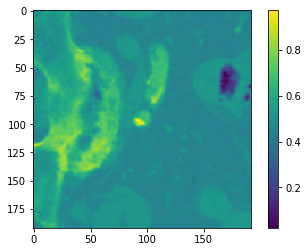

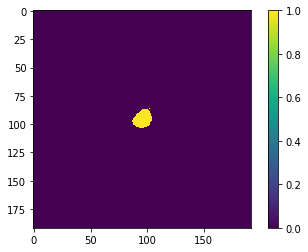

In [3]:
img = f_val.root.X[2500,:,:,0].astype(float)
plt.imshow(img.astype(np.float32))
plt.colorbar()
plt.show()

plt.figure()
seg,conts = DRLS(img)
plt.imshow(seg.astype(np.float32))
plt.colorbar()
plt.show()

In [51]:
mu = 1.0
lamda = 2.0
alpha = 1.0
R = 30

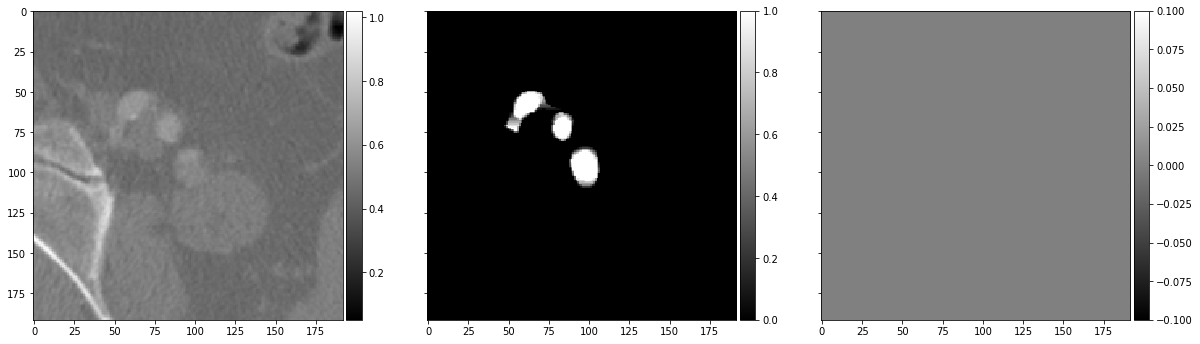

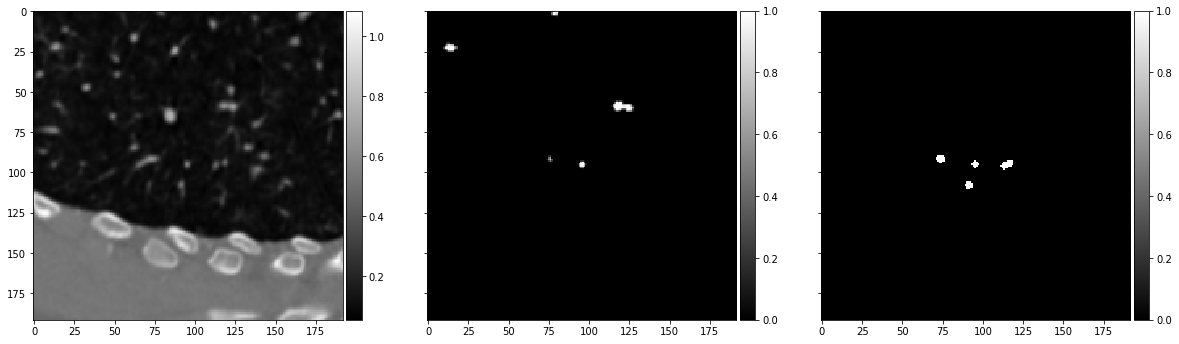

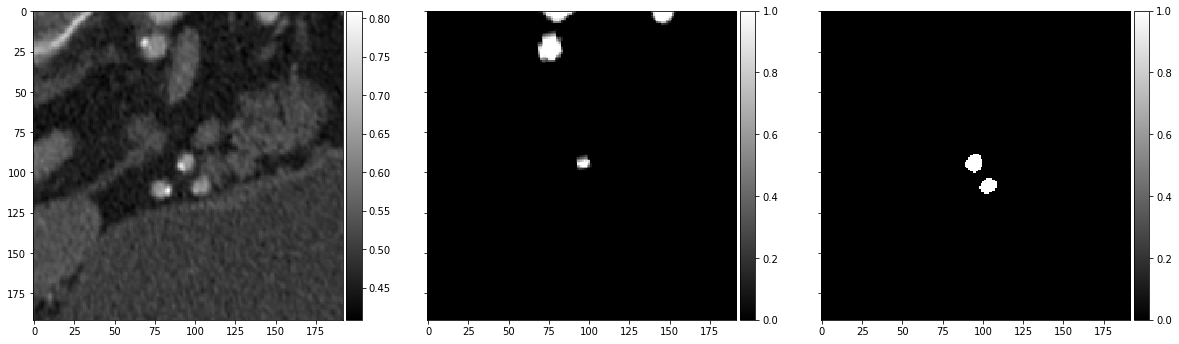

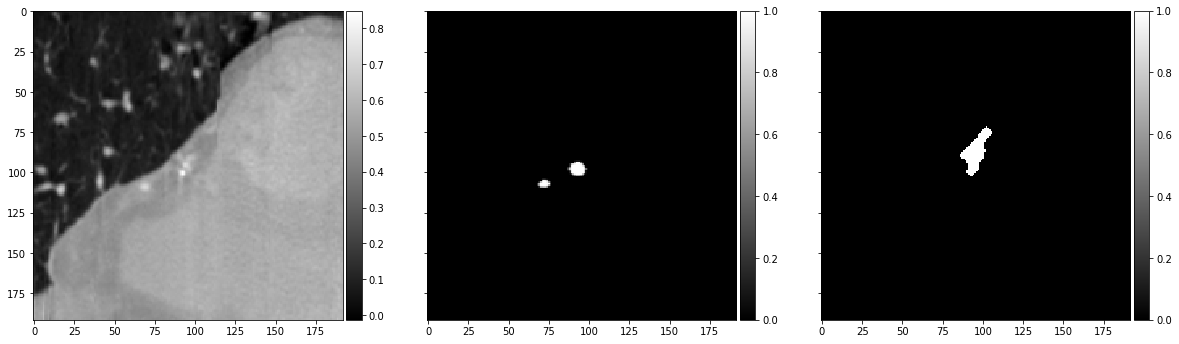

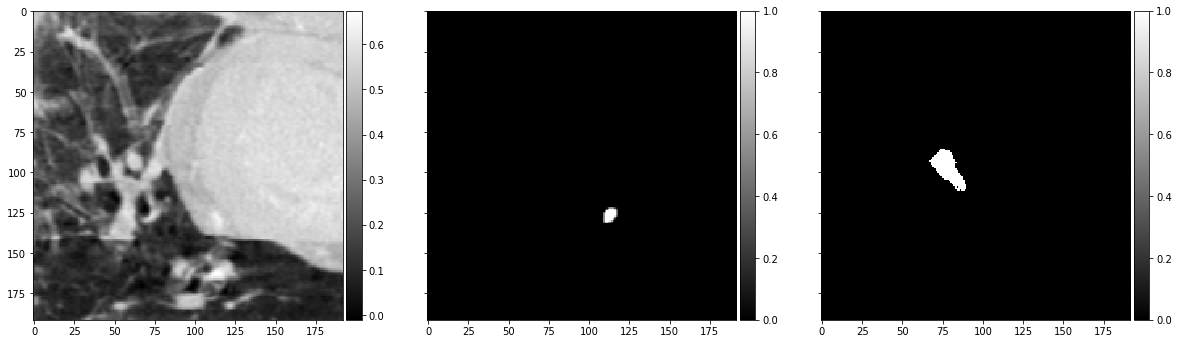

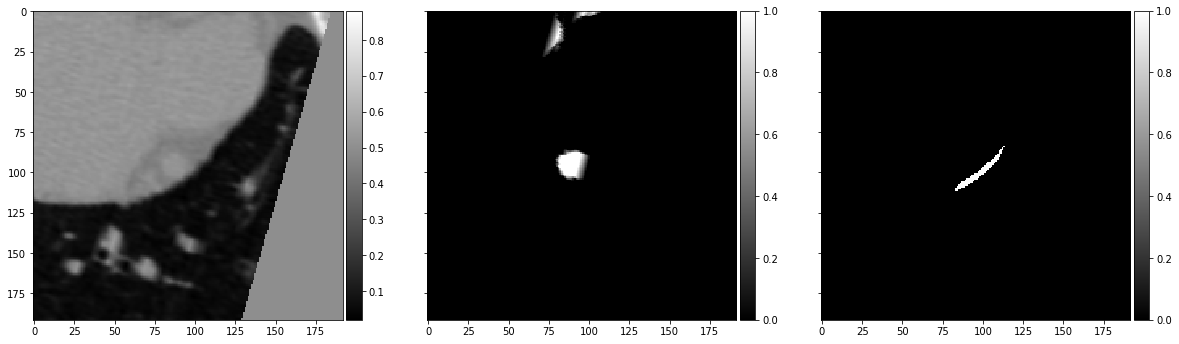

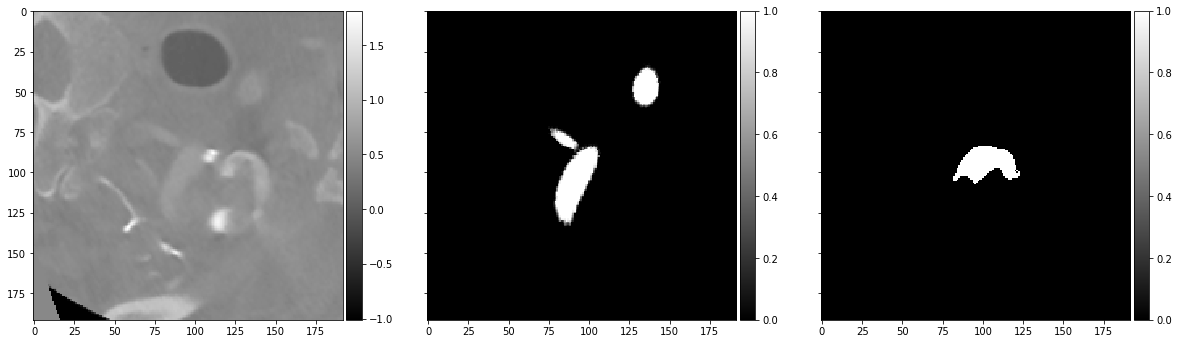

In [58]:
######################################################
# Plot
######################################################

%matplotlib inline
from mpl_toolkits.axes_grid1 import make_axes_locatable
plt.rcParams['figure.figsize'] = (20.0, 10.0)
def implot(mp,ax):
    im = ax.imshow(mp.astype(np.float32), cmap='gray')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = plt.colorbar(im, cax=cax)
 
for i in range(7):
    j = np.random.randint(N)
    im = f_train.root.X[j,:,:,0].astype(float)
    truth = f_train.root.Y[j,:,:,0].astype(float)
    seg,conts = DRLS(im,rad=R,alpha=alpha,lamda=lamda)
    plt.figure()
    fig, (ax1, ax2,ax3) = plt.subplots(1, 3, sharey=True)
    implot(im,ax1)
    implot(truth,ax2)
    implot(seg,ax3)
    plt.tight_layout
    plt.show()

In [5]:
f_test = tables.open_file(test)
X = f_test.root.X
Y = f_test.root.Y
print X.shape
print Y.shape
N,H,W,C = X.shape

(33921, 192, 192, 1)
(33921, 192, 192, 1)


In [6]:
segs = np.zeros((N,H,W))
conts = []
for i in range(N):
    if i%1000 == 0:
        print i
    img = X[i,:,:,0]
    seg,cont = DRLS(img)
    segs[i] = seg
    conts.append(cont)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000


In [7]:
np.save('drls_segs_ct.npy',segs)
np.save('drls_conts_ct.npy',conts)

In [8]:
segs = np.load('drls_segs_ct.npy')
conts = np.load('drls_conts_ct.npy')

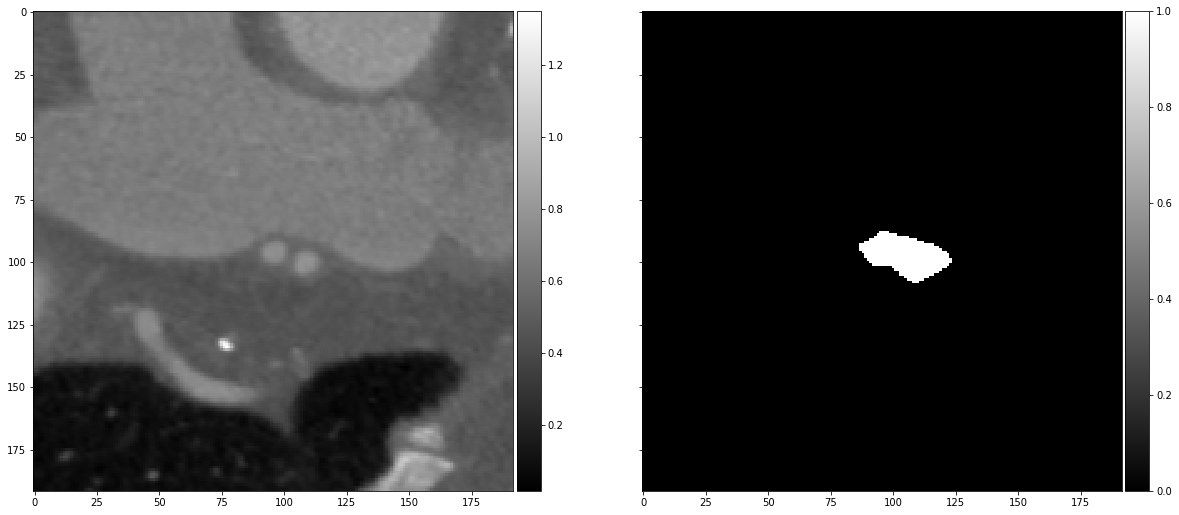

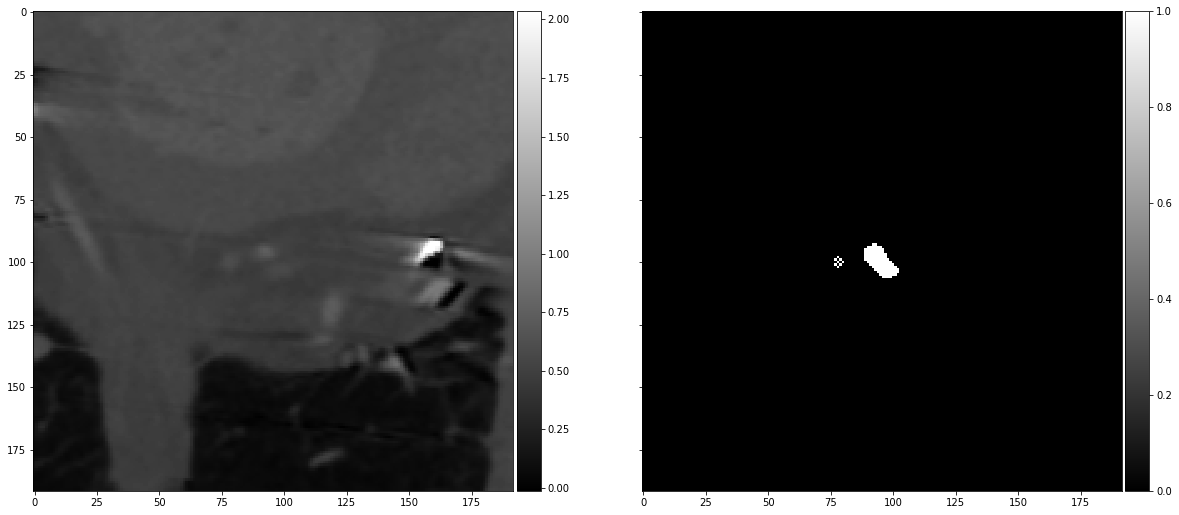

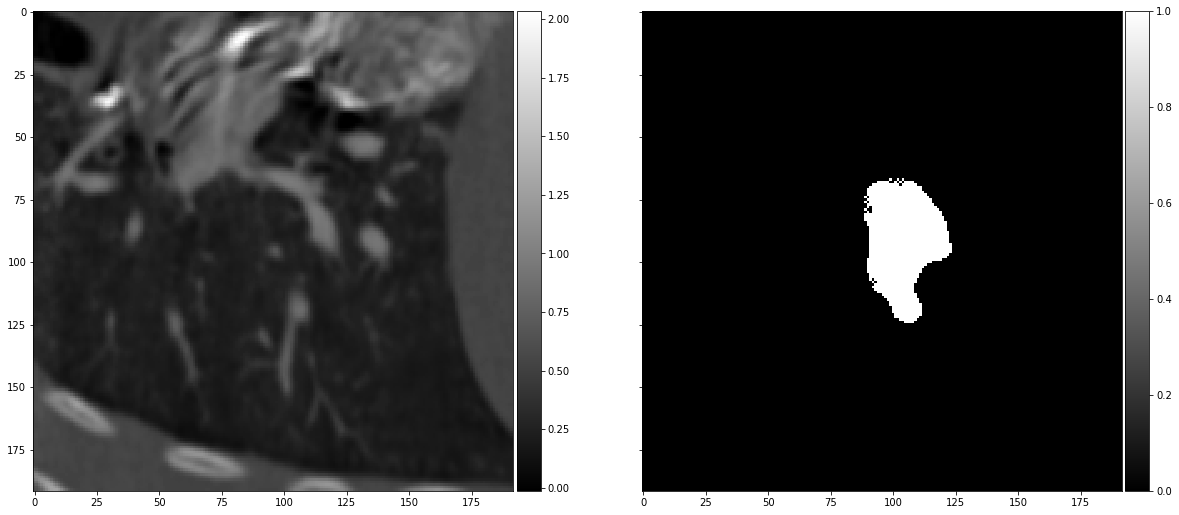

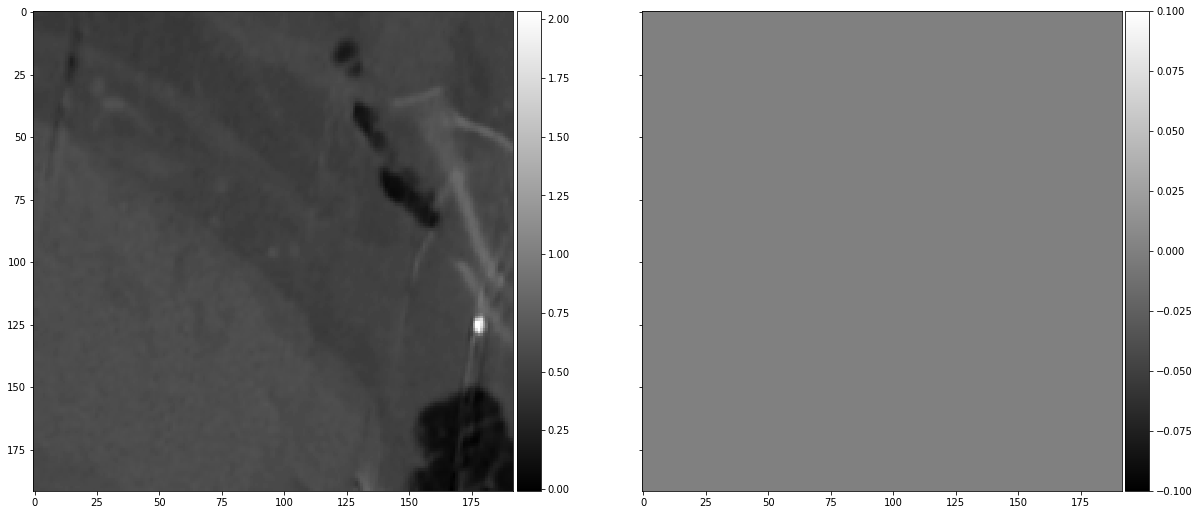

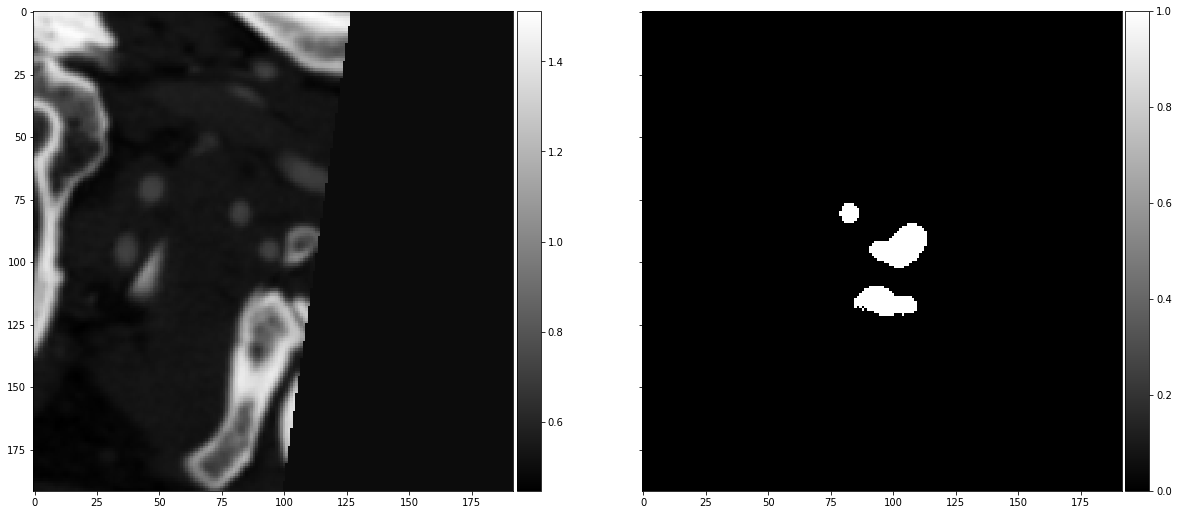

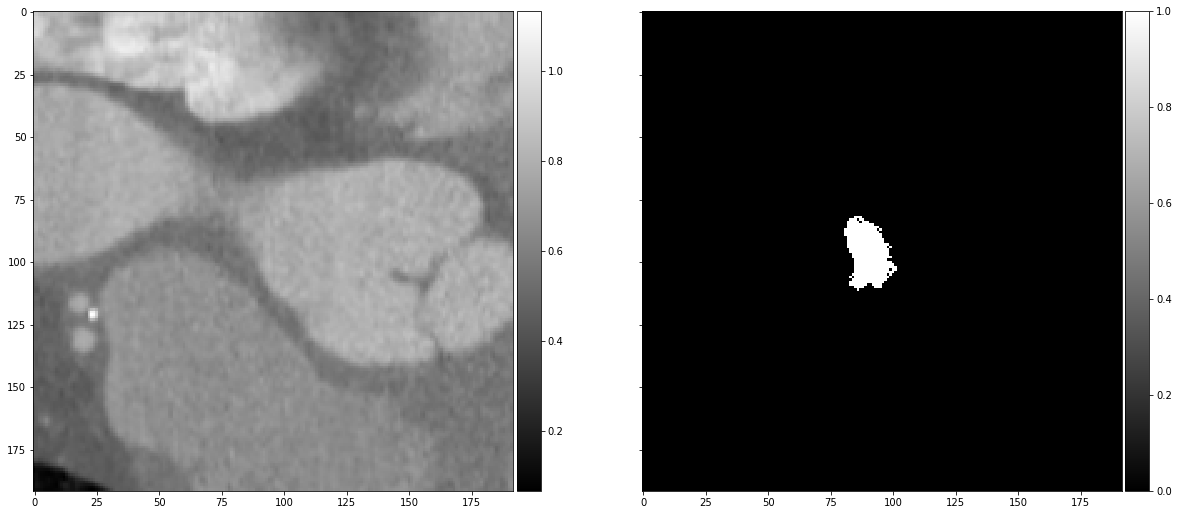

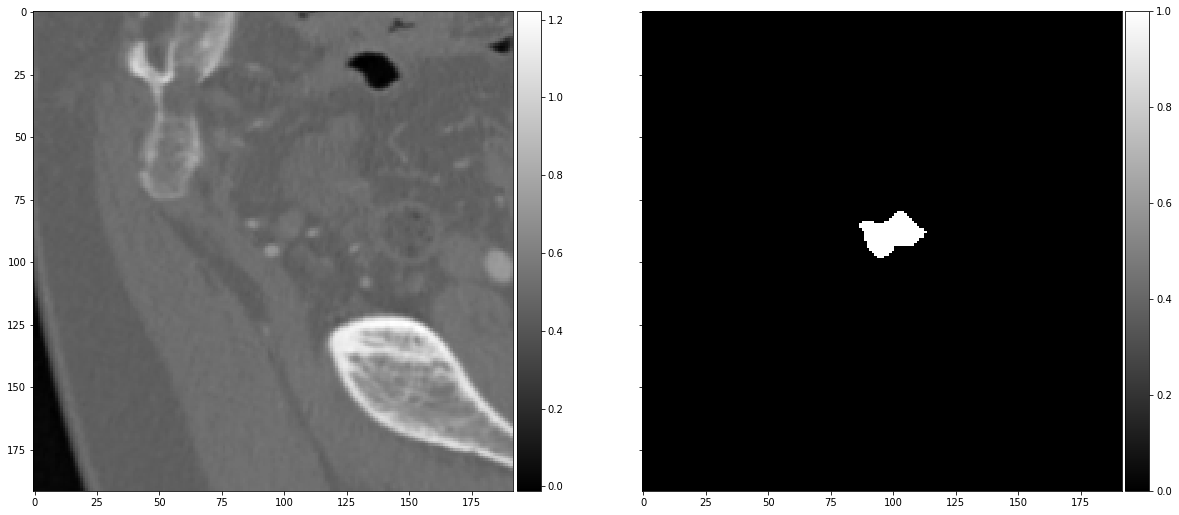

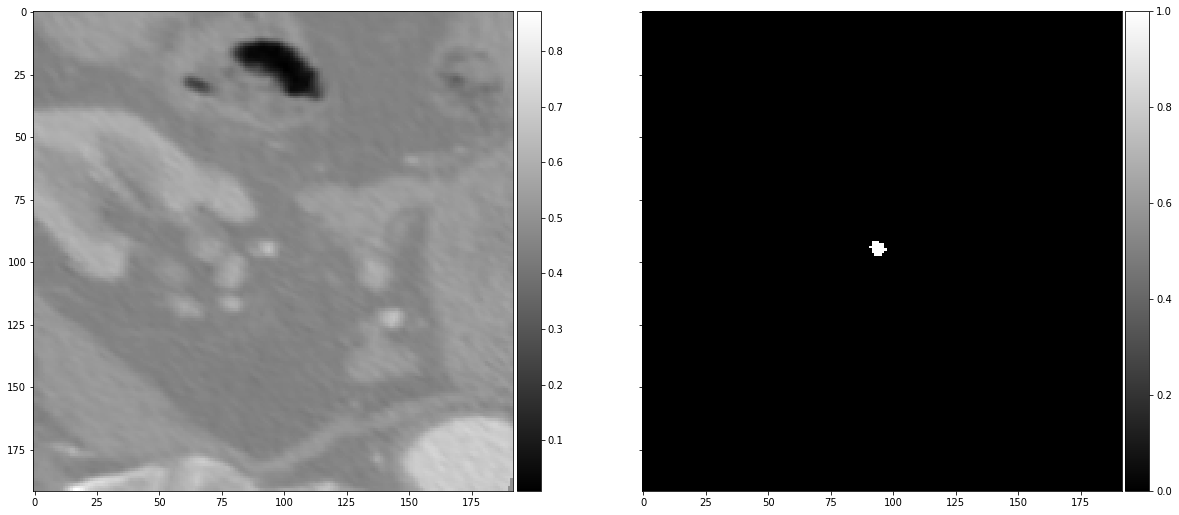

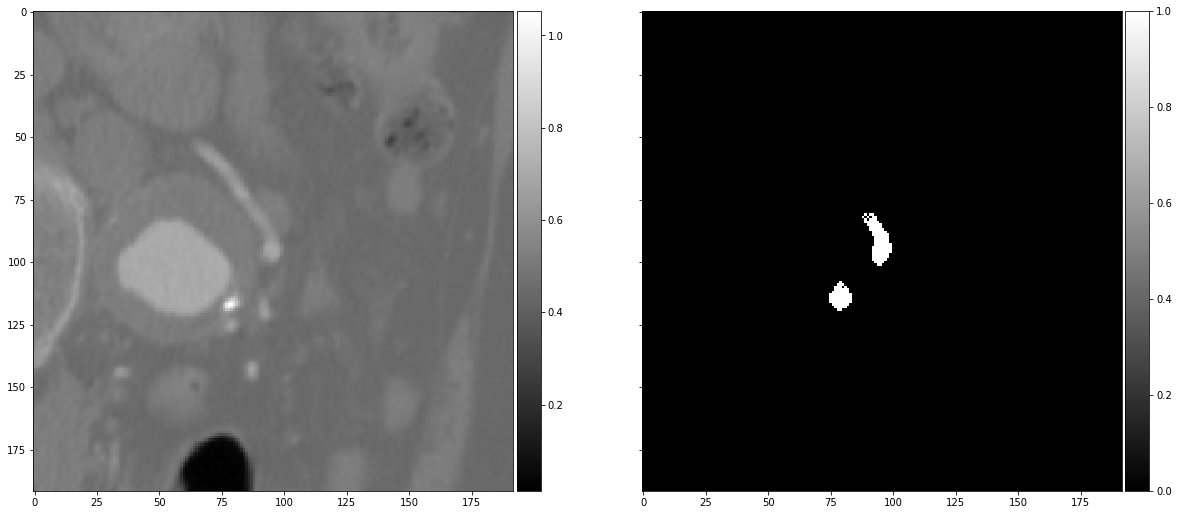

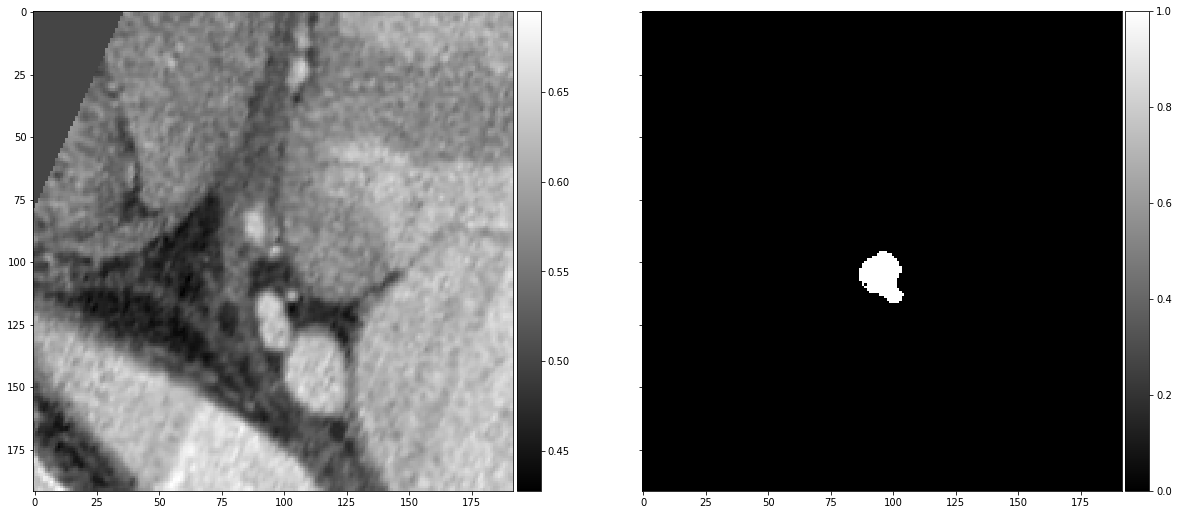

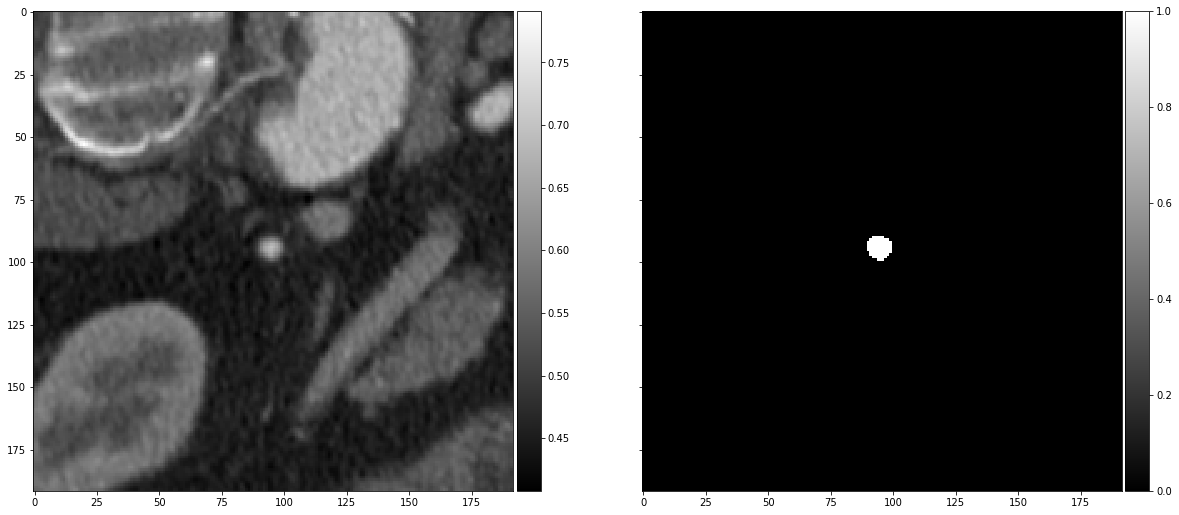

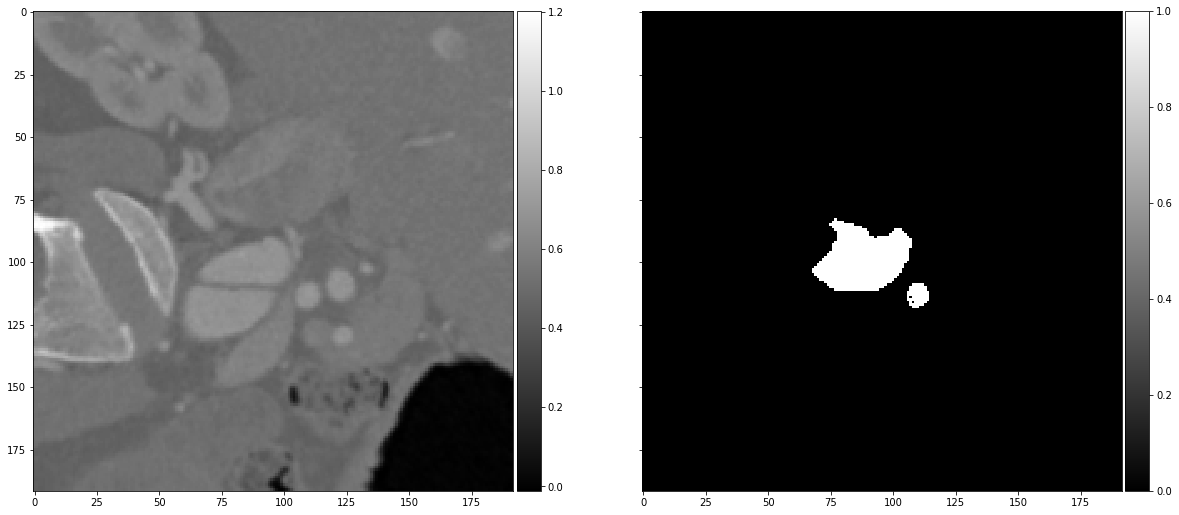

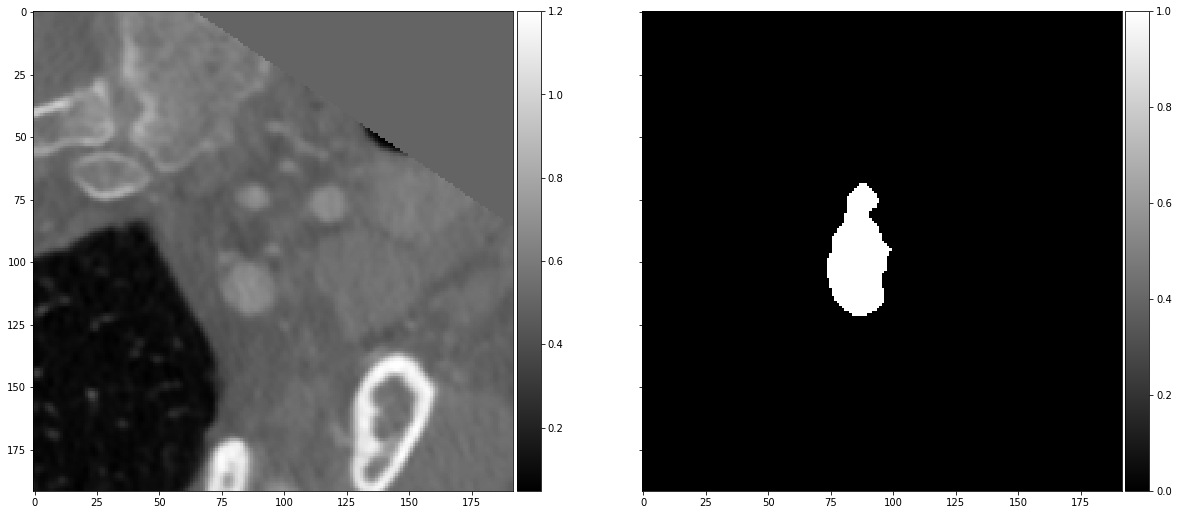

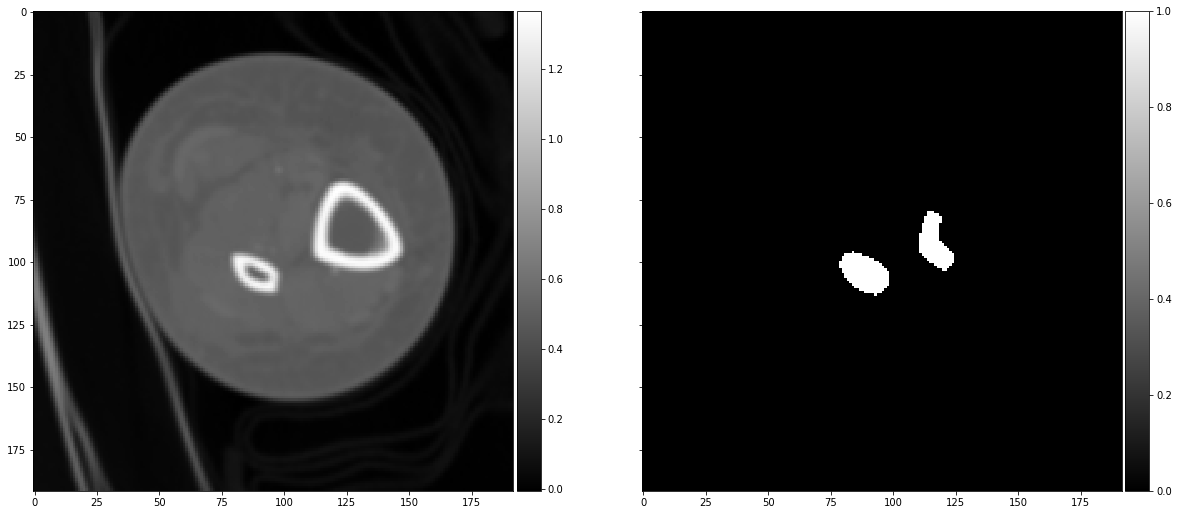

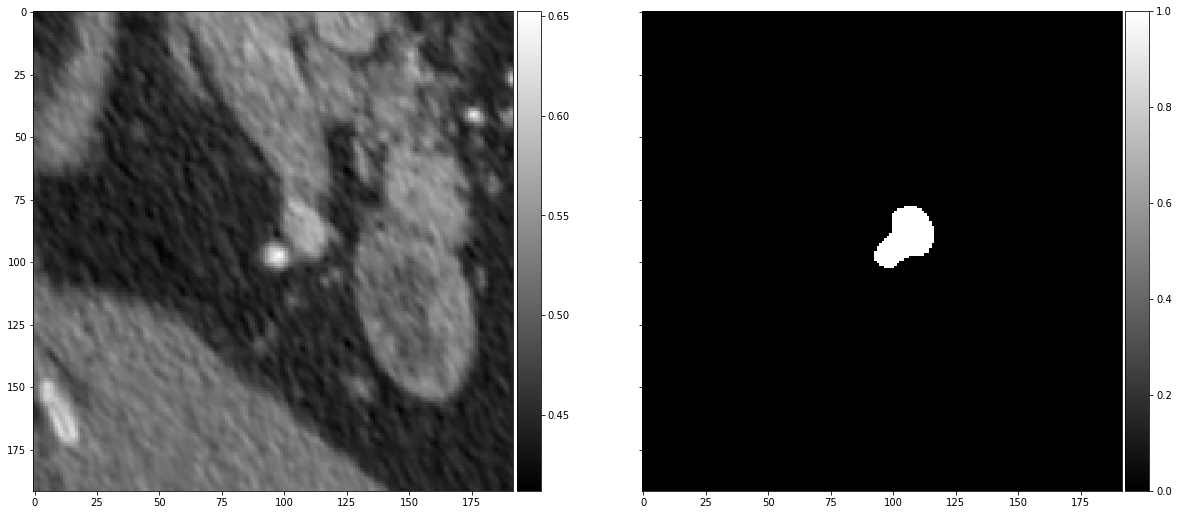

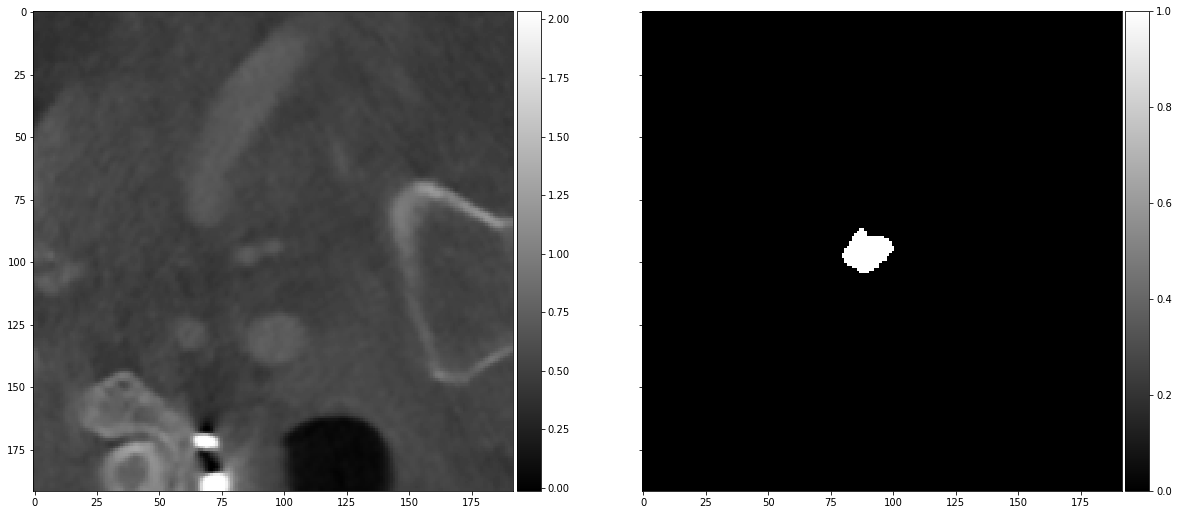

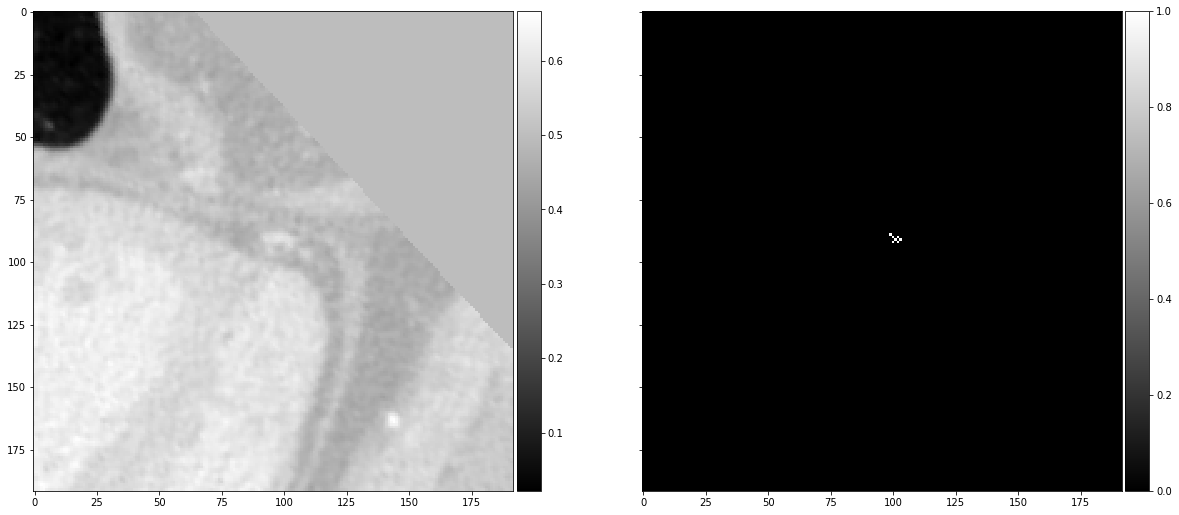

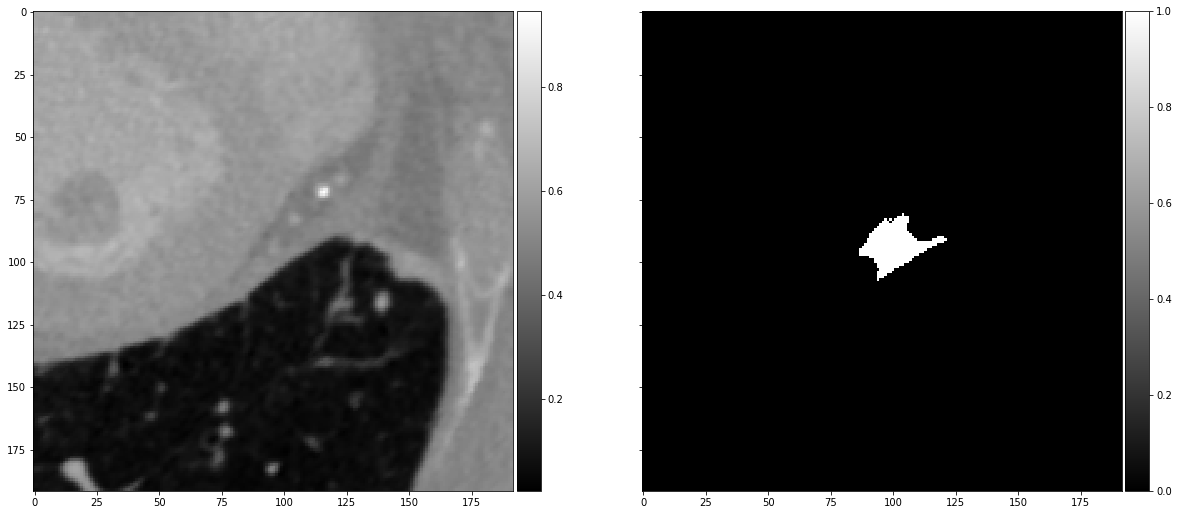

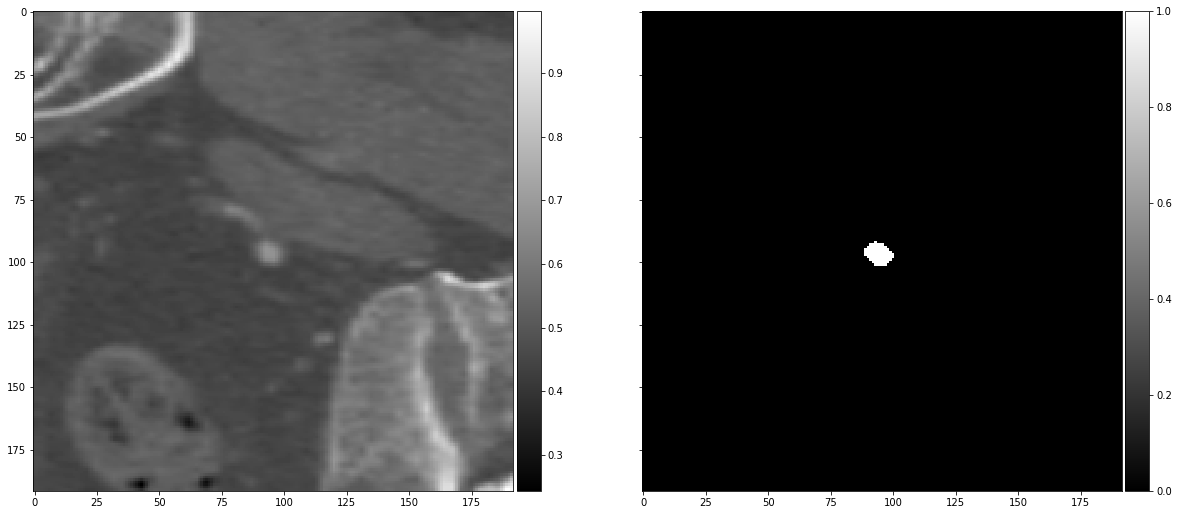

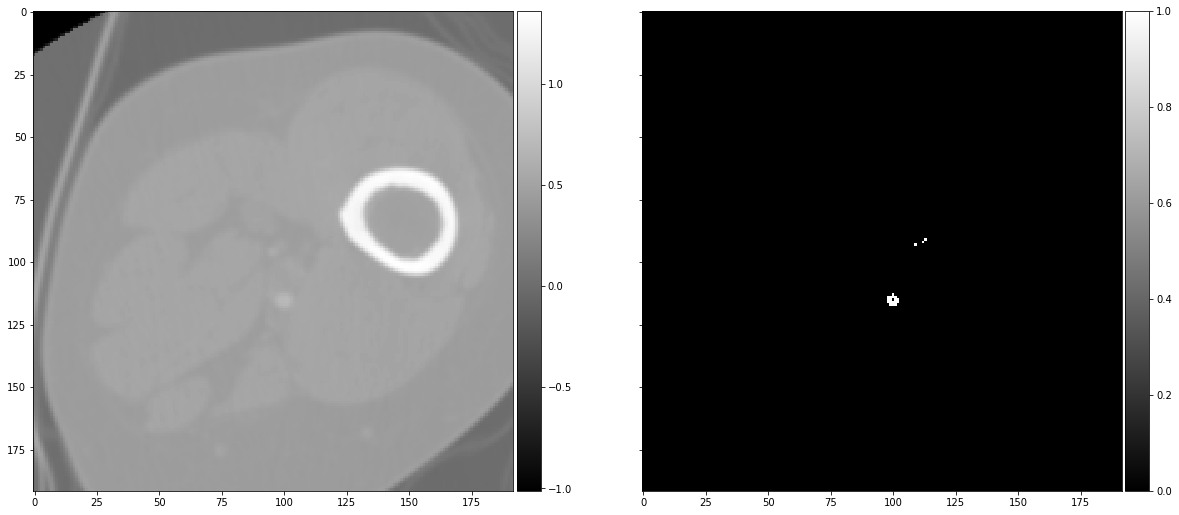

In [13]:
######################################################
# Plot
######################################################
%matplotlib inline
from mpl_toolkits.axes_grid1 import make_axes_locatable
plt.rcParams['figure.figsize'] = (20.0, 10.0)
def implot(mp,ax):
    im = ax.imshow(mp.astype(np.float32), cmap='gray')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = plt.colorbar(im, cax=cax)
 
for i in range(20):
    j = np.random.randint(N)
    im = f_test.root.X[j,:,:,0].astype(float)
    seg = segs[j,:,:].astype(float)
    plt.figure()
    fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
    implot(im,ax1)
    implot(seg,ax2)
    plt.tight_layout
    plt.show()